In [1]:
!pip install transformers datasets torch scikit-learn pandas numpy matplotlib seaborn -q


In [5]:
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

print("✓ All packages imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

2026-02-04 17:40:52.499732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770226852.978807      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770226853.117053      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770226854.228299      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770226854.228343      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770226854.228346      55 computation_placer.cc:177] computation placer alr

✓ All packages imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True


## Load the dataset

In [6]:
# Load dataset
dataset = load_dataset("artem9k/ai-text-detection-pile")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00007-bc5952582e004d(…):   0%|          | 0.00/758M [00:00<?, ?B/s]

data/train-00001-of-00007-71c80017bc45f3(…):   0%|          | 0.00/318M [00:00<?, ?B/s]

data/train-00002-of-00007-ee2d43f396e78f(…):   0%|          | 0.00/125M [00:00<?, ?B/s]

data/train-00003-of-00007-529931154b42b5(…):   0%|          | 0.00/137M [00:00<?, ?B/s]

data/train-00004-of-00007-b269dc49374a2c(…):   0%|          | 0.00/137M [00:00<?, ?B/s]

data/train-00005-of-00007-3dce5e05ddbad7(…):   0%|          | 0.00/258M [00:00<?, ?B/s]

data/train-00006-of-00007-3d8a471ba0cf1c(…):   0%|          | 0.00/242M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1392522 [00:00<?, ? examples/s]

Dataset Overview:
Total samples: 1392522

Columns: ['source', 'id', 'text']

First few rows:
  source  id                                               text
0  human   0  12 Years a Slave: An Analysis of the Film Essa...
1  human   1  20+ Social Media Post Ideas to Radically Simpl...
2  human   2  2022 Russian Invasion of Ukraine in Global Med...
3  human   3  533 U.S. 27 (2001) Kyllo v. United States: The...
4  human   4  A Charles Schwab Corporation Case Essay\n\nCha...

Class distribution:
label
0    1028146
1     364376
Name: count, dtype: int64
source
human    1028146
ai        364376
Name: count, dtype: int64

Text length statistics (words):
count    1.392522e+06
mean     4.012768e+02
std      5.667158e+02
min      0.000000e+00
25%      1.710000e+02
50%      1.930000e+02
75%      5.260000e+02
max      7.154300e+04
Name: text_length, dtype: float64


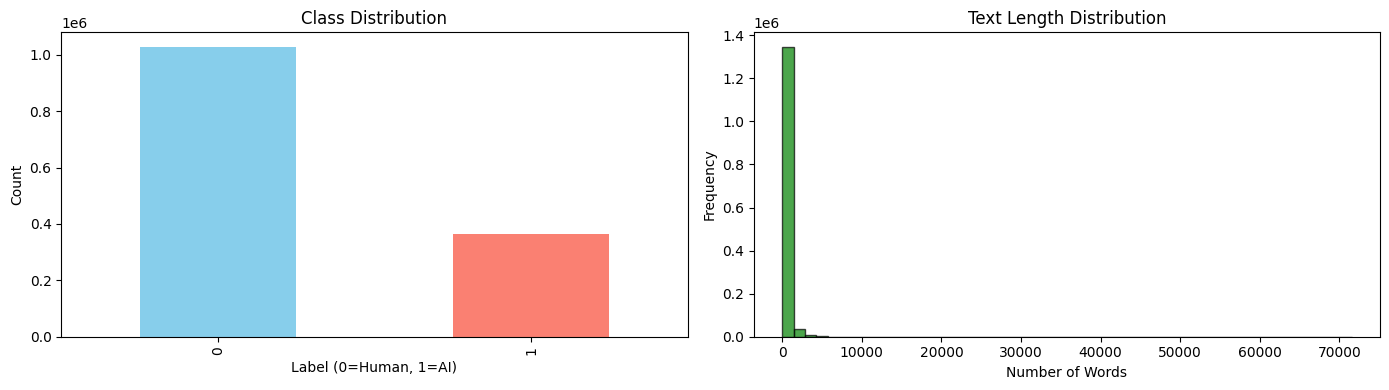

In [7]:
# Load dataset
# dataset = load_dataset("artem9k/ai-text-detection-pile")

# Convert to pandas for easier exploration
train_df = pd.DataFrame(dataset['train'])

print("Dataset Overview:")
print(f"Total samples: {len(train_df)}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(train_df.head())

# Create label from source column (human=0, ai=1)
train_df['label'] = (train_df['source'] != 'human').astype(int)

# Check class distribution
print(f"\nClass distribution:")
print(train_df['label'].value_counts())
print(train_df['source'].value_counts())

# Check text length statistics
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
print(f"\nText length statistics (words):")
print(train_df['text_length'].describe())

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Class distribution
train_df['label'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Class Distribution')
axes[0].set_xlabel('Label (0=Human, 1=AI)')
axes[0].set_ylabel('Count')

# Text length distribution
axes[1].hist(train_df['text_length'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Text Length Distribution')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
print(train_df['text_length'].describe())
print(f"\nMin: {train_df['text_length'].min()}")
print(f"Max: {train_df['text_length'].max()}")
print(f"Median: {train_df['text_length'].median()}")

count    1.392522e+06
mean     4.012768e+02
std      5.667158e+02
min      0.000000e+00
25%      1.710000e+02
50%      1.930000e+02
75%      5.260000e+02
max      7.154300e+04
Name: text_length, dtype: float64

Min: 0
Max: 71543
Median: 193.0


## Preprocessing

In [9]:
# Preprocessing function (adapted from paper, without Arabic-specific steps)
def preprocess_text(text):
    """
    Preprocess text by:
    - Removing excessive punctuation
    - Normalizing whitespace
    - Removing repeated characters
    """
    if not isinstance(text, str):
        return ""
    
    # Remove excessive punctuation (keep single occurrences)
    text = re.sub(r'([!?.,]){2,}', r'\1', text)
    
    # Remove repeated characters (e.g., "hellooo" -> "hello")
    text = re.sub(r'(.)\1{3,}', r'\1\1', text)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    return text

# Apply preprocessing
print("Applying preprocessing...")
train_df['text_clean'] = train_df['text'].apply(preprocess_text)

print("✓ Preprocessing complete!")
print("\nExample before:")
print(train_df['text'].iloc[0][:200])
print("\nExample after:")
print(train_df['text_clean'].iloc[0][:200])

# Categorize texts by length (in tokens, approximate with words)
def categorize_length(word_count):
    if word_count < 512:
        return 'short'
    elif word_count < 1024:
        return 'mid'
    else:
        return 'long'

train_df['length_category'] = train_df['text_length'].apply(categorize_length)
print(f"\nLength category distribution:")
print(train_df['length_category'].value_counts())

Applying preprocessing...
✓ Preprocessing complete!

Example before:
12 Years a Slave: An Analysis of the Film Essay

The 2013 film 12 Years a Slave proved that slavery is a worldwide issue. Indeed, the film made $150 million outside the United States and $57 million i

Example after:
12 Years a Slave: An Analysis of the Film Essay The 2013 film 12 Years a Slave proved that slavery is a worldwide issue. Indeed, the film made $150 million outside the United States and $57 million in

Length category distribution:
length_category
short    1038037
mid       287014
long       67471
Name: count, dtype: int64


In [17]:
SAMPLE_SIZE = 10000  # Set to None to use full dataset
if SAMPLE_SIZE:
    train_df = train_df.sample(n=min(SAMPLE_SIZE, len(train_df)), random_state=42).reset_index(drop=True)
    print(f"Using {len(train_df)} samples for training")

# Split into train and test (80/20)
train_data, test_data = train_test_split(
    train_df[['text_clean', 'label', 'text_length', 'length_category']], 
    test_size=0.2, 
    random_state=42,
    stratify=train_df['label']
)

print(f"\nTrain set: {len(train_data)} samples")
print(f"Test set: {len(test_data)} samples")

print(f"\nTrain class distribution:")
print(train_data['label'].value_counts())

print(f"\nTest class distribution:")
print(test_data['label'].value_counts())

# Reset indices
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print("\n✓ Train/test split complete!")

# Initialize tokenizer and fix length categories based on tokens
print("\n" + "="*60)
print("FIXING LENGTH CATEGORIES BASED ON TOKEN COUNTS")
print("="*60)

Using 10000 samples for training

Train set: 8000 samples
Test set: 2000 samples

Train class distribution:
label
0    5823
1    2177
Name: count, dtype: int64

Test class distribution:
label
0    1456
1     544
Name: count, dtype: int64

✓ Train/test split complete!

FIXING LENGTH CATEGORIES BASED ON TOKEN COUNTS


## Chunking

In [18]:
def chunk_text(text, tokenizer, chunk_size=400, overlap=50):
    """
    Split text into overlapping chunks.
    
    Args:
        text: Input text string
        tokenizer: Hugging Face tokenizer
        chunk_size: Maximum tokens per chunk (default 400)
        overlap: Overlap between chunks (default 50)
    
    Returns:
        List of text chunks
    """
    # Tokenize the full text
    tokens = tokenizer.encode(text, add_special_tokens=False)
    
    # If text is shorter than chunk_size, return as single chunk
    if len(tokens) <= chunk_size:
        return [text]
    
    chunks = []
    start = 0
    
    while start < len(tokens):
        # Get chunk of tokens
        end = min(start + chunk_size, len(tokens))
        chunk_tokens = tokens[start:end]
        
        # Decode back to text
        chunk_text = tokenizer.decode(chunk_tokens, skip_special_tokens=True)
        chunks.append(chunk_text)
        
        # Move start position (with overlap)
        start += (chunk_size - overlap)
        
        # Break if we've reached the end
        if end == len(tokens):
            break
    
    return chunks

# Test chunking function
test_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
test_text = train_data['text_clean'].iloc[0]

print(f"Original text length: {len(test_text.split())} words")
test_chunks = chunk_text(test_text, test_tokenizer, chunk_size=400, overlap=50)
print(f"Number of chunks created: {len(test_chunks)}")
print(f"\nFirst chunk preview:\n{test_chunks[0][:200]}...")
if len(test_chunks) > 1:
    print(f"\nSecond chunk preview:\n{test_chunks[1][:200]}...")

print("\n✓ Chunking function ready!")

Original text length: 165 words
Number of chunks created: 1

First chunk preview:
hing. As usual.'' ``All we have.'' ``Maybe the boys in the lab'll find something, Mick. The things they can do these days.'' ``Nah'', I crooned as I waved him off. ``Wont make a bit o' difference. Wha...

✓ Chunking function ready!


In [19]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Check text lengths
train_data['token_count'] = train_data['text_clean'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))
test_data['token_count'] = test_data['text_clean'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))

print(f"{'='*60}")
print(f"TEXT LENGTH DISTRIBUTION (in tokens)")
print(f"{'='*60}")

print("\nTRAINING SET:")
print(f"Short (<512 tokens):    {len(train_data[train_data['token_count'] < 512])} samples")
print(f"Mid (512-1024 tokens):  {len(train_data[(train_data['token_count'] >= 512) & (train_data['token_count'] < 1024)])} samples")
print(f"Long (>1024 tokens):    {len(train_data[train_data['token_count'] >= 1024])} samples")
print(f"Total:                  {len(train_data)} samples")

print("\nTEST SET:")
print(f"Short (<512 tokens):    {len(test_data[test_data['token_count'] < 512])} samples")
print(f"Mid (512-1024 tokens):  {len(test_data[(test_data['token_count'] >= 512) & (test_data['token_count'] < 1024)])} samples")
print(f"Long (>1024 tokens):    {len(test_data[test_data['token_count'] >= 1024])} samples")
print(f"Total:                  {len(test_data)} samples")

print(f"\nMax tokens in training: {train_data['token_count'].max()}")
print(f"Max tokens in test:     {test_data['token_count'].max()}")

Token indices sequence length is longer than the specified maximum sequence length for this model (991 > 512). Running this sequence through the model will result in indexing errors


TEXT LENGTH DISTRIBUTION (in tokens)

TRAINING SET:
Short (<512 tokens):    5568 samples
Mid (512-1024 tokens):  1568 samples
Long (>1024 tokens):    864 samples
Total:                  8000 samples

TEST SET:
Short (<512 tokens):    1408 samples
Mid (512-1024 tokens):  391 samples
Long (>1024 tokens):    201 samples
Total:                  2000 samples

Max tokens in training: 21623
Max tokens in test:     9041


## Create Dataset

In [20]:
from torch.utils.data import Dataset

class TextDataset(Dataset):
    """Dataset without chunking - standard approach"""
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

class ChunkedTextDataset(Dataset):
    """Dataset with chunking - stores chunk info for aggregation"""
    def __init__(self, texts, labels, tokenizer, chunk_size=400, overlap=50):
        self.tokenizer = tokenizer
        self.chunk_size = chunk_size
        self.overlap = overlap
        
        self.chunks = []
        self.chunk_labels = []
        self.doc_ids = []  # Track which document each chunk belongs to
        
        # Create chunks for each document
        for doc_id, (text, label) in enumerate(zip(texts, labels)):
            text_chunks = chunk_text(text, tokenizer, chunk_size, overlap)
            
            for chunk in text_chunks:
                self.chunks.append(chunk)
                self.chunk_labels.append(label)
                self.doc_ids.append(doc_id)
        
        print(f"Created {len(self.chunks)} chunks from {len(texts)} documents")
    
    def __len__(self):
        return len(self.chunks)
    
    def __getitem__(self, idx):
        chunk = str(self.chunks[idx])
        label = self.chunk_labels[idx]
        
        encoding = self.tokenizer(
            chunk,
            truncation=True,
            padding='max_length',
            max_length=512,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
            'doc_id': torch.tensor(self.doc_ids[idx], dtype=torch.long)
        }

print("✓ Dataset classes created!")

✓ Dataset classes created!


## Training and Testing Definition

In [21]:
def compute_metrics(pred):
    """Compute metrics for evaluation"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def train_model(model_name, train_dataset, eval_dataset, output_dir, epochs=3):
    """Train a transformer model"""
    
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=2
    )
    
    # Training arguments (from paper: batch=16, lr=2e-5, epochs=5, weight_decay=0.001)
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=2e-5,
        weight_decay=0.001,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        logging_steps=100,
        seed=42
    )
    
    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics
    )
    
    # Train
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")
    trainer.train()
    
    return trainer, tokenizer

def evaluate_without_chunking(trainer, test_data):
    """Evaluate model without chunking (standard)"""
    predictions = trainer.predict(test_data)
    preds = predictions.predictions.argmax(-1)
    labels = predictions.label_ids
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'predictions': preds,
        'labels': labels
    }

print("✓ Training and evaluation functions ready!")

✓ Training and evaluation functions ready!


## Chunked Evaluation

In [22]:
def evaluate_with_chunking(trainer, chunked_test_dataset, original_test_labels):
    """
    Evaluate model with chunking and aggregation.
    Aggregate chunk predictions by document ID using mean confidence scores.
    """
    # Get predictions for all chunks
    predictions = trainer.predict(chunked_test_dataset)
    
    # Get probabilities (softmax of logits)
    probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)
    
    # Get confidence scores for class 1 (AI-generated)
    confidence_scores = probs[:, 1].numpy()
    
    # Get document IDs for each chunk
    doc_ids = [chunked_test_dataset[i]['doc_id'].item() for i in range(len(chunked_test_dataset))]
    
    # Aggregate predictions by document
    doc_predictions = {}
    
    for doc_id, conf_score in zip(doc_ids, confidence_scores):
        if doc_id not in doc_predictions:
            doc_predictions[doc_id] = []
        doc_predictions[doc_id].append(conf_score)
    
    # Calculate mean confidence per document and make final prediction
    final_preds = []
    for doc_id in sorted(doc_predictions.keys()):
        mean_confidence = np.mean(doc_predictions[doc_id])
        final_pred = 1 if mean_confidence >= 0.5 else 0
        final_preds.append(final_pred)
    
    final_preds = np.array(final_preds)
    labels = np.array(original_test_labels)
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, final_preds, average='binary')
    acc = accuracy_score(labels, final_preds)
    
    print(f"\nAggregation info:")
    print(f"Total chunks: {len(confidence_scores)}")
    print(f"Total documents: {len(doc_predictions)}")
    print(f"Average chunks per document: {len(confidence_scores) / len(doc_predictions):.2f}")
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'predictions': final_preds,
        'labels': labels
    }

print("✓ Chunked evaluation function ready!")

✓ Chunked evaluation function ready!


## Bert-Model

### without Chunking

In [23]:
# Model configuration
MODEL_NAME = 'bert-base-uncased'
EPOCHS = 3  # Set to 5 for full training as in paper

print(f"{'='*60}")
print(f"EXPERIMENT 1: {MODEL_NAME} WITHOUT CHUNKING")
print(f"{'='*60}")

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Create datasets WITHOUT chunking
train_dataset_no_chunk = TextDataset(
    texts=train_data['text_clean'].tolist(),
    labels=train_data['label'].tolist(),
    tokenizer=tokenizer,
    max_length=512
)

test_dataset_no_chunk = TextDataset(
    texts=test_data['text_clean'].tolist(),
    labels=test_data['label'].tolist(),
    tokenizer=tokenizer,
    max_length=512
)

print(f"\nDataset sizes:")
print(f"Train: {len(train_dataset_no_chunk)} samples")
print(f"Test: {len(test_dataset_no_chunk)} samples")

# Load model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir='./bert_no_chunk',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.001,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=50,
    logging_dir='./logs',
    report_to="none",
    seed=42,
    disable_tqdm=False
)

# Create trainer
trainer_no_chunk = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_no_chunk,
    eval_dataset=test_dataset_no_chunk,
    compute_metrics=compute_metrics
)

# Train
print(f"\nTraining...")
trainer_no_chunk.train()

# Evaluate
results_no_chunk = evaluate_without_chunking(trainer_no_chunk, test_dataset_no_chunk)

print(f"\n{'='*60}")
print(f"RESULTS - {MODEL_NAME} WITHOUT CHUNKING:")
print(f"{'='*60}")
print(f"Accuracy:  {results_no_chunk['accuracy']:.4f}")
print(f"Precision: {results_no_chunk['precision']:.4f}")
print(f"Recall:    {results_no_chunk['recall']:.4f}")
print(f"F1-Score:  {results_no_chunk['f1']:.4f}")

EXPERIMENT 1: bert-base-uncased WITHOUT CHUNKING

Dataset sizes:
Train: 8000 samples
Test: 2000 samples


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.129600,0.350596,0.865500,0.800000,0.671660,0.988971
2,0.087100,0.448164,0.889000,0.829493,0.712401,0.992647
3,0.036500,0.521026,0.888500,0.828329,0.712583,0.988971



RESULTS - bert-base-uncased WITHOUT CHUNKING:
Accuracy:  0.8890
Precision: 0.7124
Recall:    0.9926
F1-Score:  0.8295


### With Chunking

In [24]:
print(f"\n{'='*60}")
print(f"EXPERIMENT 2: {MODEL_NAME} WITH CHUNKING")
print(f"{'='*60}")

# Create datasets WITH chunking
train_dataset_chunk = ChunkedTextDataset(
    texts=train_data['text_clean'].tolist(),
    labels=train_data['label'].tolist(),
    tokenizer=tokenizer,
    chunk_size=400,
    overlap=50
)

test_dataset_chunk = ChunkedTextDataset(
    texts=test_data['text_clean'].tolist(),
    labels=test_data['label'].tolist(),
    tokenizer=tokenizer,
    chunk_size=400,
    overlap=50
)

# Load fresh model
model_chunk = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Training arguments
training_args_chunk = TrainingArguments(
    output_dir='./bert_with_chunk',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.001,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=50,
    logging_dir='./logs_chunk',
    report_to="none",
    seed=42,
    disable_tqdm=False
)

# Create trainer
trainer_chunk = Trainer(
    model=model_chunk,
    args=training_args_chunk,
    train_dataset=train_dataset_chunk,
    eval_dataset=test_dataset_chunk,
    compute_metrics=compute_metrics
)

# Train
print(f"\nTraining with chunking...")
trainer_chunk.train()

# Evaluate with chunking aggregation
results_chunk = evaluate_with_chunking(
    trainer_chunk, 
    test_dataset_chunk, 
    test_data['label'].tolist()
)

print(f"\n{'='*60}")
print(f"RESULTS - {MODEL_NAME} WITH CHUNKING:")
print(f"{'='*60}")
print(f"Accuracy:  {results_chunk['accuracy']:.4f}")
print(f"Precision: {results_chunk['precision']:.4f}")
print(f"Recall:    {results_chunk['recall']:.4f}")
print(f"F1-Score:  {results_chunk['f1']:.4f}")

Token indices sequence length is longer than the specified maximum sequence length for this model (991 > 512). Running this sequence through the model will result in indexing errors



EXPERIMENT 2: bert-base-uncased WITH CHUNKING
Created 14795 chunks from 8000 documents
Created 3592 chunks from 2000 documents


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training with chunking...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.141000,0.521021,0.822383,0.751751,0.606403,0.988741
2,0.087300,0.283621,0.920935,0.870438,0.785185,0.976459
3,0.025700,0.514927,0.893374,0.834127,0.722973,0.985670



Aggregation info:
Total chunks: 3592
Total documents: 2000
Average chunks per document: 1.80

RESULTS - bert-base-uncased WITH CHUNKING:
Accuracy:  0.9260
Precision: 0.7964
Recall:    0.9779
F1-Score:  0.8779


### Visualization


BERT COMPARISON: WITH vs WITHOUT CHUNKING
        Approach  Precision    Recall  F1-Score  Accuracy
Without Chunking   0.712401  0.992647  0.829493     0.889
   With Chunking   0.796407  0.977941  0.877888     0.926
       Delta (Δ)   0.084006 -0.014706  0.048395     0.037


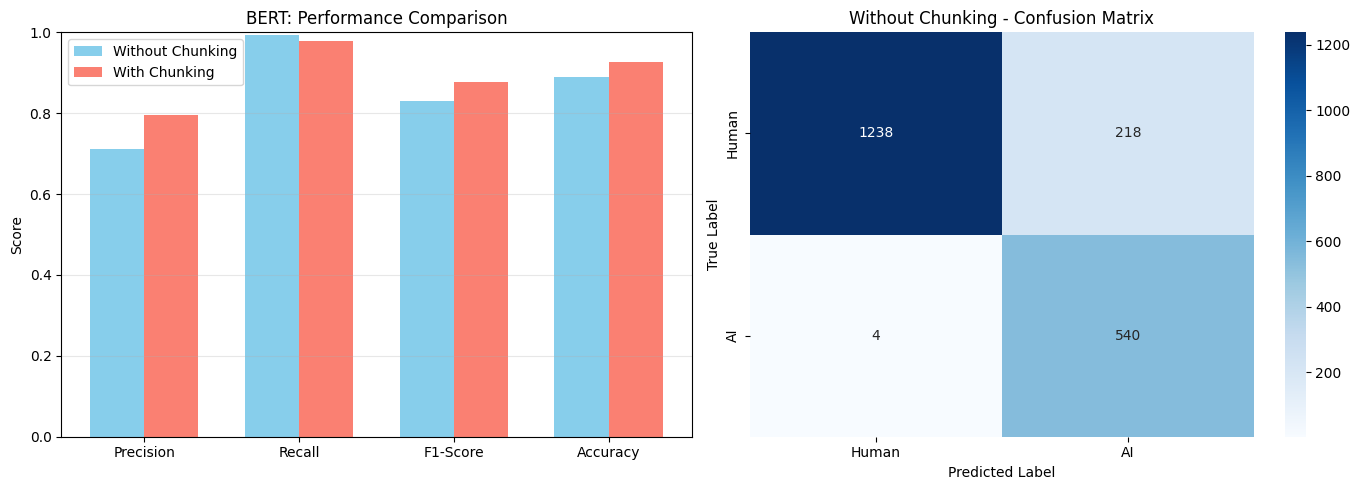

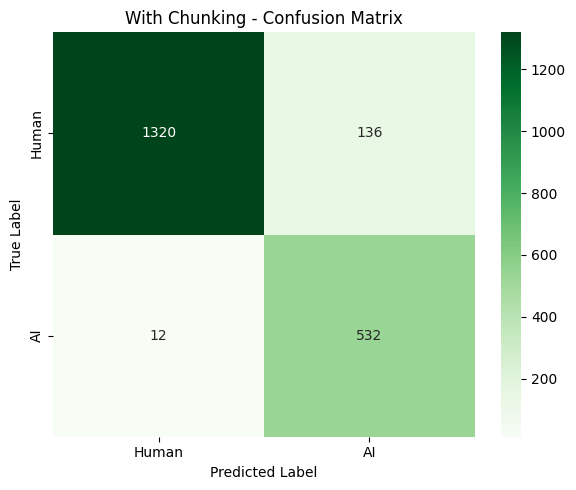


✓ BERT experiments complete!


In [25]:
# Compare results
print(f"\n{'='*60}")
print(f"BERT COMPARISON: WITH vs WITHOUT CHUNKING")
print(f"{'='*60}")

comparison_df = pd.DataFrame({
    'Approach': ['Without Chunking', 'With Chunking', 'Delta (Δ)'],
    'Precision': [
        results_no_chunk['precision'],
        results_chunk['precision'],
        results_chunk['precision'] - results_no_chunk['precision']
    ],
    'Recall': [
        results_no_chunk['recall'],
        results_chunk['recall'],
        results_chunk['recall'] - results_no_chunk['recall']
    ],
    'F1-Score': [
        results_no_chunk['f1'],
        results_chunk['f1'],
        results_chunk['f1'] - results_no_chunk['f1']
    ],
    'Accuracy': [
        results_no_chunk['accuracy'],
        results_chunk['accuracy'],
        results_chunk['accuracy'] - results_no_chunk['accuracy']
    ]
})

print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart comparison
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
no_chunk_vals = [results_no_chunk['precision'], results_no_chunk['recall'], 
                  results_no_chunk['f1'], results_no_chunk['accuracy']]
chunk_vals = [results_chunk['precision'], results_chunk['recall'], 
              results_chunk['f1'], results_chunk['accuracy']]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, no_chunk_vals, width, label='Without Chunking', color='skyblue')
axes[0].bar(x + width/2, chunk_vals, width, label='With Chunking', color='salmon')
axes[0].set_ylabel('Score')
axes[0].set_title('BERT: Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)

# Confusion matrices
cm_no_chunk = confusion_matrix(results_no_chunk['labels'], results_no_chunk['predictions'])
cm_chunk = confusion_matrix(results_chunk['labels'], results_chunk['predictions'])

# Without chunking
sns.heatmap(cm_no_chunk, annot=True, fmt='d', cmap='Blues', ax=axes[1], 
            xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
axes[1].set_title('Without Chunking - Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Confusion matrix for chunking
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.heatmap(cm_chunk, annot=True, fmt='d', cmap='Greens', ax=ax,
            xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
ax.set_title('With Chunking - Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\n✓ BERT experiments complete!")

### Length-Based Evaluation

BERT WITHOUT CHUNKING - Performance by Text Length

SHORT texts (n=1509):
  Precision: 0.7262
  Recall:    0.9917
  F1-Score:  0.8384

MID texts (n=408):
  Precision: 0.7054
  Recall:    0.9945
  F1-Score:  0.8254

LONG texts (n=83):
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

BERT WITH CHUNKING - Performance by Text Length

SHORT texts (n=1509):
  Precision: 0.7905
  Recall:    0.9723
  F1-Score:  0.8720

MID texts (n=408):
  Precision: 0.8080
  Recall:    0.9891
  F1-Score:  0.8894

LONG texts (n=83):
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000


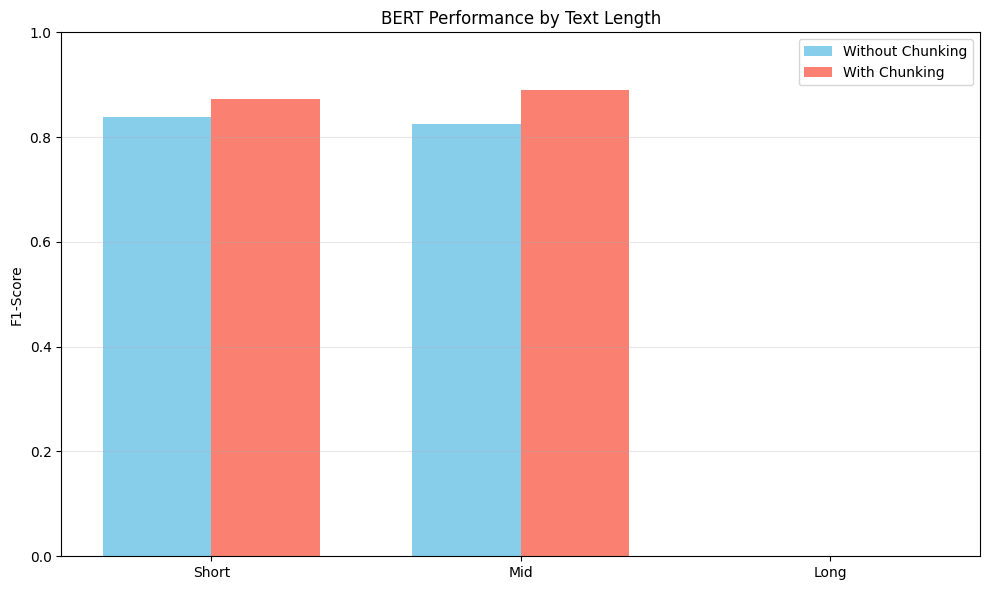


✓ Length-based analysis complete!


In [27]:
def evaluate_by_length(predictions, labels, test_data_df):
    """
    Evaluate performance separately for short, mid, and long texts
    """
    results_by_length = {}
    
    for length_cat in ['short', 'mid', 'long']:
        # Get indices for this length category
        indices = test_data_df[test_data_df['length_category'] == length_cat].index.tolist()
        
        if len(indices) == 0:
            results_by_length[length_cat] = {
                'precision': 0, 'recall': 0, 'f1': 0, 'count': 0
            }
            continue
        
        # Get predictions and labels for this category
        cat_preds = predictions[indices]
        cat_labels = labels[indices]
        
        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            cat_labels, cat_preds, average='binary', zero_division=0
        )
        
        results_by_length[length_cat] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'count': len(indices)
        }
    
    return results_by_length

# Evaluate BERT without chunking by length
print(f"{'='*60}")
print(f"BERT WITHOUT CHUNKING - Performance by Text Length")
print(f"{'='*60}")

results_no_chunk_by_length = evaluate_by_length(
    results_no_chunk['predictions'],
    results_no_chunk['labels'],
    test_data
)

for length_cat in ['short', 'mid', 'long']:
    res = results_no_chunk_by_length[length_cat]
    print(f"\n{length_cat.upper()} texts (n={res['count']}):")
    print(f"  Precision: {res['precision']:.4f}")
    print(f"  Recall:    {res['recall']:.4f}")
    print(f"  F1-Score:  {res['f1']:.4f}")

# Evaluate BERT with chunking by length
print(f"\n{'='*60}")
print(f"BERT WITH CHUNKING - Performance by Text Length")
print(f"{'='*60}")

results_chunk_by_length = evaluate_by_length(
    results_chunk['predictions'],
    results_chunk['labels'],
    test_data
)

for length_cat in ['short', 'mid', 'long']:
    res = results_chunk_by_length[length_cat]
    print(f"\n{length_cat.upper()} texts (n={res['count']}):")
    print(f"  Precision: {res['precision']:.4f}")
    print(f"  Recall:    {res['recall']:.4f}")
    print(f"  F1-Score:  {res['f1']:.4f}")

# Create comparison visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

length_categories = ['Short', 'Mid', 'Long']
x = np.arange(len(length_categories))
width = 0.35

f1_no_chunk = [results_no_chunk_by_length['short']['f1'],
               results_no_chunk_by_length['mid']['f1'],
               results_no_chunk_by_length['long']['f1']]

f1_chunk = [results_chunk_by_length['short']['f1'],
            results_chunk_by_length['mid']['f1'],
            results_chunk_by_length['long']['f1']]

ax.bar(x - width/2, f1_no_chunk, width, label='Without Chunking', color='skyblue')
ax.bar(x + width/2, f1_chunk, width, label='With Chunking', color='salmon')

ax.set_ylabel('F1-Score')
ax.set_title('BERT Performance by Text Length')
ax.set_xticks(x)
ax.set_xticklabels(length_categories)
ax.legend()
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Length-based analysis complete!")